# Data Modelling Lab Project 
**Topic:** Neural Machine Translation

**Name:** Srinithi S L

**SC Code:** SC25M168

**Course:** Data Modelling Lab 

**Code Implementation in this file:** Parallel Request Processing

## Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import asyncio
from typing import List, Dict
import time
from tqdm.notebook import tqdm
import pandas as pd
from torchsummary import summary
from collections import Counter
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Connect to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Transformer Architecture

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            while mask.dim() < 4:
                mask = mask.unsqueeze(1)
            if mask.size(-1) != scores.size(-1) or mask.size(-2) != scores.size(-2):
                if mask.size(-1) == scores.size(-1):
                    mask = mask.expand(scores.size(0), 1, scores.size(-2), scores.size(-1))
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        context = torch.matmul(attention, V)
        return context, attention
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.w_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        context, attention = self.scaled_dot_product_attention(Q, K, V, mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.w_o(context)
        return output

In [5]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.cross_attn = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, n_heads=8, n_layers=6, d_ff=2048, max_len=50):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(0.1)
        
    def create_padding_mask(self, seq, pad_idx=0):
        mask = (seq != pad_idx).float()
        return mask.unsqueeze(1).unsqueeze(1)
    
    def create_look_ahead_mask(self, size, device):
        mask = torch.tril(torch.ones((size, size), device=device))
        return mask.unsqueeze(0).unsqueeze(0)
    
    def forward(self, src, tgt):
        batch_size, src_len = src.size()
        tgt_len = tgt.size(1)
        src_mask = self.create_padding_mask(src).to(src.device)
        tgt_padding_mask = self.create_padding_mask(tgt).to(tgt.device)
        tgt_look_ahead_mask = self.create_look_ahead_mask(tgt_len, tgt.device)
        tgt_mask = tgt_padding_mask * tgt_look_ahead_mask
        src_emb = self.dropout(self.pos_encoding(self.src_embedding(src) * math.sqrt(self.d_model)))
        tgt_emb = self.dropout(self.pos_encoding(self.tgt_embedding(tgt) * math.sqrt(self.d_model)))
        enc_output = src_emb
        for layer in self.encoder_layers:
            enc_output = layer(enc_output, src_mask)
        dec_output = tgt_emb
        for layer in self.decoder_layers:
            dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)
        output = self.output_projection(dec_output)
        return output

## Data Preprocessing and Trained Model Loading

In [9]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.vocab_size = 4
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.vocab_size
            self.idx2word[self.vocab_size] = word
            self.vocab_size += 1

In [10]:
def load_model(model_path='nmt_transformer_model.pth'):
    print(f"Loading model from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    eng_vocab = checkpoint['eng_vocab']
    fr_vocab = checkpoint['fr_vocab']
    model_config = checkpoint['model_config']
    model = Transformer(src_vocab_size=model_config['src_vocab_size'],tgt_vocab_size=model_config['tgt_vocab_size'], d_model=model_config['d_model'],
        n_heads=model_config['n_heads'], n_layers=model_config['n_layers'],d_ff=model_config['d_ff'],max_len=model_config['max_len']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"English vocab size: {eng_vocab.vocab_size}")
    print(f"French vocab size: {fr_vocab.vocab_size}")
    return model, eng_vocab, fr_vocab

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
    
def encode_sentence(sentence, vocab, max_len=50):
    sentence = preprocess_text(sentence)
    indices = []
    for word in sentence.split():
        indices.append(vocab.word2idx.get(word, vocab.word2idx['<UNK>']))
    indices.append(vocab.word2idx['<EOS>'])
    
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        indices.extend([vocab.word2idx['<PAD>']] * (max_len - len(indices)))
    
    return torch.tensor(indices, dtype=torch.long).unsqueeze(0)

def decode_sequence(indices, vocab):
    words = []
    for idx in indices:
        if idx == vocab.word2idx['<EOS>']:
            break
        if idx not in [vocab.word2idx['<PAD>'], vocab.word2idx['<SOS>']]:
            words.append(vocab.idx2word[idx])
    return ' '.join(words)

def translate_sentence(model, sentence, eng_vocab, fr_vocab, max_len=50):
    model.eval()
    with torch.no_grad():
        src = encode_sentence(sentence, eng_vocab, max_len).to(device)
        tgt_indices = [fr_vocab.word2idx['<SOS>']]
        for _ in range(max_len):
            tgt = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(0).to(device)
            # Pad to maximum length
            if tgt.size(1) < max_len:
                padding = torch.full((1, max_len - tgt.size(1)), fr_vocab.word2idx['<PAD>'], dtype=torch.long).to(device)
                tgt = torch.cat([tgt, padding], dim=1)
            output = model(src, tgt)
            next_token = output[0, len(tgt_indices)-1].argmax().item()
            tgt_indices.append(next_token)
            if next_token == fr_vocab.word2idx['<EOS>']:
                break
        translation = decode_sequence(tgt_indices, fr_vocab)
        return translation

## Parallel Request Processing (Parallel Translator)

In [12]:
class ParallelTranslator:
    def __init__(self, model, eng_vocab, fr_vocab, max_workers=4):
        self.model = model
        self.eng_vocab = eng_vocab
        self.fr_vocab = fr_vocab
        self.max_workers = max_workers
        
    def translate_single(self, request_id, sentence):
        start_time = time.time()
        translation = translate_sentence(self.model, sentence, self.eng_vocab, self.fr_vocab)
        end_time = time.time()
        
        return {'request_id': request_id,'input': sentence,'translation': translation,'time_taken': end_time - start_time}
    
    def translate_batch_parallel(self, sentences: List[str]) -> List[Dict]:
        results = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_request = {executor.submit(self.translate_single, i, sent): i for i, sent in enumerate(sentences)}
            for future in tqdm(as_completed(future_to_request), total=len(sentences), desc="Translating"):
                try:
                    result = future.result()
                    results.append(result)
                except Exception as e:
                    request_id = future_to_request[future]
                    results.append({'request_id': request_id,'input': sentences[request_id],'translation': f'ERROR: {str(e)}', 'time_taken': 0})
        results.sort(key=lambda x: x['request_id'])
        return results
        
    def translate_batch_sequential(self, sentences: List[str]) -> List[Dict]:
        """Translate multiple sentences sequentially (for comparison)"""
        results = []
        for i, sentence in enumerate(tqdm(sentences, desc="Translating (Sequential)")):
            result = self.translate_single(i, sentence)
            results.append(result)
        return results

In [13]:
def compare_parallel_vs_sequential(translator, sentences):
    print("PERFORMANCE COMPARISON: Parallel vs Sequential")
    # Sequential processing
    print("\n Running Sequential Processing...")
    start_seq = time.time()
    results_seq = translator.translate_batch_sequential(sentences)
    time_seq = time.time() - start_seq
    # Parallel processing
    print("\n Running Parallel Processing...")
    start_par = time.time()
    results_par = translator.translate_batch_parallel(sentences)
    time_par = time.time() - start_par
    
    print(f"\n Results:")
    print(f"  Sequential Time: {time_seq:.2f} seconds")
    print(f"  Parallel Time:   {time_par:.2f} seconds")
    print(f"  Speedup:         {time_seq/time_par:.2f}x")
    print(f"  Time Saved:      {time_seq - time_par:.2f} seconds ({((time_seq-time_par)/time_seq)*100:.1f}%)")
    
    return results_seq, results_par, time_seq, time_par

def display_results(results, title="Translation Results"):
    print(f"\n{title}")
    df = pd.DataFrame(results)
    df['time_taken'] = df['time_taken'].apply(lambda x: f"{x:.3f}s")
    print(df.to_string(index=False))
    return df

In [15]:
# Load model
model, eng_vocab, fr_vocab = load_model('nmt_transformer_model.pth')
print("\n DETAILED MODEL ARCHITECTURE")

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
total, trainable = count_parameters(model)

print(f"\n Model Statistics:")
print(f"  Total Parameters:     {total:,}")
print(f"  Trainable Parameters: {trainable:,}")
print(f"  Non-trainable Params: {total - trainable:,}")
print(f"  Model Size (MB):      {total * 4 / (1024**2):.2f}")
print(f"\n Architecture Details:")
print(f"  Source Vocab Size:    {model.src_embedding.num_embeddings:,}")
print(f"  Target Vocab Size:    {model.tgt_embedding.num_embeddings:,}")
print(f"  Embedding Dimension:  {model.d_model}")
print(f"  Number of Layers:     {len(model.encoder_layers)}")
print(f"  Attention Heads:      {model.encoder_layers[0].self_attn.n_heads}")
print(f"  Max Sequence Length:  {model.max_len}")
print(f"\n Layer-wise Parameters:")

def print_layer_params(name, module):
    params = sum(p.numel() for p in module.parameters())
    print(f"  {name:<40} {params:>15,} params")
# Embeddings
print_layer_params("Source Embedding", model.src_embedding)
print_layer_params("Target Embedding", model.tgt_embedding)

# Encoder
encoder_params = sum(sum(p.numel() for p in layer.parameters()) for layer in model.encoder_layers)
print(f"\n  {'Encoder (Total)':<40} {encoder_params:>15,} params")
for i, layer in enumerate(model.encoder_layers):
    layer_params = sum(p.numel() for p in layer.parameters())
    print(f"    Layer {i+1:<35} {layer_params:>15,} params")

# Decoder
decoder_params = sum(sum(p.numel() for p in layer.parameters()) for layer in model.decoder_layers)
print(f"\n  {'Decoder (Total)':<40} {decoder_params:>15,} params")
for i, layer in enumerate(model.decoder_layers):
    layer_params = sum(p.numel() for p in layer.parameters())
    print(f"    Layer {i+1:<35} {layer_params:>15,} params")

print_layer_params("\nOutput Projection", model.output_projection)
print("FULL MODEL ARCHITECTURE")
print(model)

# Create parallel translator
translator = ParallelTranslator(model, eng_vocab, fr_vocab, max_workers=4)
test_sentences = [
    "hello world",
    "good morning",
    "how are you",
    "thank you very much",
    "i love programming",
    "the weather is nice today",
    "what is your name",
    "where are you from",
    "have a nice day",
    "see you tomorrow"
]
print("PARALLEL TRANSLATION REQUEST PROCESSING DEMO")
print(f"\nNumber of test sentences: {len(test_sentences)}")
print(f"Max parallel workers: {translator.max_workers}")

#Comparison
results_seq, results_par, time_seq, time_par = compare_parallel_vs_sequential(translator, test_sentences)
df_results = display_results(results_par, "Parallel Translation Results")
print("\n DETAILED STATISTICS")
avg_time = sum(r['time_taken'] for r in results_par) / len(results_par)
print(f"Average translation time per sentence: {avg_time:.3f}s")
print(f"Total sentences processed: {len(results_par)}")
print(f"Throughput: {len(results_par)/time_par:.2f} sentences/second")

print("\n SINGLE TRANSLATION EXAMPLE")
example = "hello how are you"
print(f"Input:  {example}")
result = translator.translate_single(0, example)
print(f"Output: {result['translation']}")
print(f"Time:   {result['time_taken']:.3f}s")

Loading model from nmt_transformer_model.pth...
English vocab size: 10003
French vocab size: 17973

 DETAILED MODEL ARCHITECTURE

 Model Statistics:
  Total Parameters:     67,682,357
  Trainable Parameters: 67,682,357
  Non-trainable Params: 0
  Model Size (MB):      258.19

 Architecture Details:
  Source Vocab Size:    10,003
  Target Vocab Size:    17,973
  Embedding Dimension:  512
  Number of Layers:     6
  Attention Heads:      8
  Max Sequence Length:  50

 Layer-wise Parameters:
  Source Embedding                               5,121,536 params
  Target Embedding                               9,202,176 params

  Encoder (Total)                               18,914,304 params
    Layer 1                                         3,152,384 params
    Layer 2                                         3,152,384 params
    Layer 3                                         3,152,384 params
    Layer 4                                         3,152,384 params
    Layer 5                    

Translating (Sequential):   0%|          | 0/10 [00:00<?, ?it/s]


 Running Parallel Processing...


Translating:   0%|          | 0/10 [00:00<?, ?it/s]


 Results:
  Sequential Time: 2.64 seconds
  Parallel Time:   0.85 seconds
  Speedup:         3.11x
  Time Saved:      1.79 seconds (67.8%)

Parallel Translation Results
 request_id                     input             translation time_taken
          0               hello world        bonjour le monde     0.363s
          1              good morning             bonne matin     0.283s
          2               how are you           comment ça va     0.355s
          3       thank you very much          merci beaucoup     0.279s
          4        i love programming      jadore les douleur     0.277s
          5 the weather is nice today il fait beau aujourdhui     0.362s
          6         what is your name        comment sappelle     0.207s
          7        where are you from          doù vous venez     0.297s
          8           have a nice day passe une bonne journée     0.271s
          9          see you tomorrow                à demain     0.195s

 DETAILED STATISTICS
Avera

## BLEU - Score Implementation for Model Evaluation

In [16]:
class BLEUScore:
    def __init__(self):
        self.name = "BLEU Score Evaluator"
    
    def _get_ngrams(self, tokens: List[str], n: int) -> Counter:
        ngrams = []
        for i in range(len(tokens) - n + 1):
            ngrams.append(tuple(tokens[i:i+n]))
        return Counter(ngrams)
    
    def _modified_precision(self, candidate: List[str], reference: List[str], n: int) -> float:
        candidate_ngrams = self._get_ngrams(candidate, n)
        reference_ngrams = self._get_ngrams(reference, n)
        
        if sum(candidate_ngrams.values()) == 0:
            return 0.0
        
        clipped_counts = 0
        for ngram, count in candidate_ngrams.items():
            clipped_counts += min(count, reference_ngrams.get(ngram, 0))
        
        precision = clipped_counts / sum(candidate_ngrams.values())
        return precision
    
    def _brevity_penalty(self, candidate_length: int, reference_length: int) -> float:
        if candidate_length >= reference_length:
            return 1.0
        else:
            return math.exp(1 - reference_length / candidate_length)
    
    def sentence_bleu(self, candidate: str, reference: str, max_n: int = 4, 
                     weights: List[float] = None, smooth: bool = True) -> Dict[str, float]:
        #Tokenize
        candidate_tokens = candidate.lower().split()
        reference_tokens = reference.lower().split()

        actual_max_n = min(max_n, len(candidate_tokens), len(reference_tokens))
        if actual_max_n == 0:
            actual_max_n = 1
        
        if weights is None:
            weights = [1.0 / actual_max_n] * actual_max_n
        
        result = {f'bleu-{i}': 0.0 for i in range(1, max_n + 1)}
        result['bleu'] = 0.0
        result['brevity_penalty'] = 0.0
        result['length_ratio'] = 0.0
        
        if len(candidate_tokens) == 0:
            return result
        precisions = {}
        log_precision_sum = 0
        
        for n in range(1, actual_max_n + 1):
            prec = self._modified_precision(candidate_tokens, reference_tokens, n)
            
            #Handling zero precisions
            if smooth and prec == 0:
                prec = 1.0 / (2 ** n)              
            precisions[f'bleu-{n}'] = prec
            result[f'bleu-{n}'] = prec
            
            if prec > 0:
                log_precision_sum += weights[n-1] * math.log(prec)
        
        for n in range(actual_max_n + 1, max_n + 1):
            result[f'bleu-{n}'] = float('nan')  # Not applicable
        
        #Brevity penalty
        bp = self._brevity_penalty(len(candidate_tokens), len(reference_tokens))
        
        #Final BLEU score
        result['bleu'] = bp * math.exp(log_precision_sum)
        result['brevity_penalty'] = bp
        result['length_ratio'] = len(candidate_tokens) / len(reference_tokens) if len(reference_tokens) > 0 else 0
        result['effective_max_n'] = actual_max_n
        
        return result
    
    def corpus_bleu(self, candidates: List[str], references: List[str], 
                   max_n: int = 4, weights: List[float] = None) -> Dict[str, float]:
        if len(candidates) != len(references):
            raise ValueError("Number of candidates must match number of references")
        
        if weights is None:
            weights = [1.0 / max_n] * max_n

        total_candidate_length = 0
        total_reference_length = 0
        clipped_counts = {n: 0 for n in range(1, max_n + 1)}
        total_counts = {n: 0 for n in range(1, max_n + 1)}
        
        for candidate, reference in zip(candidates, references):
            candidate_tokens = candidate.lower().split()
            reference_tokens = reference.lower().split()
            
            total_candidate_length += len(candidate_tokens)
            total_reference_length += len(reference_tokens)
            
            for n in range(1, max_n + 1):
                candidate_ngrams = self._get_ngrams(candidate_tokens, n)
                reference_ngrams = self._get_ngrams(reference_tokens, n)
                
                for ngram, count in candidate_ngrams.items():
                    clipped_counts[n] += min(count, reference_ngrams.get(ngram, 0))
                
                total_counts[n] += sum(candidate_ngrams.values())
        
        precisions = {}
        log_precision_sum = 0
        has_zero_precision = False
        
        for n in range(1, max_n + 1):
            if total_counts[n] > 0:
                prec = clipped_counts[n] / total_counts[n]
                precisions[f'bleu-{n}'] = prec
                if prec > 0:
                    log_precision_sum += weights[n-1] * math.log(prec)
                else:
                    has_zero_precision = True
            else:
                precisions[f'bleu-{n}'] = 0.0
                has_zero_precision = True
        
        #Brevity penalty
        bp = self._brevity_penalty(total_candidate_length, total_reference_length)
        
        #Final BLEU score
        if has_zero_precision:
            bleu = 0.0
        else:
            bleu = bp * math.exp(log_precision_sum)
        
        precisions['bleu'] = bleu
        precisions['brevity_penalty'] = bp
        precisions['avg_length_ratio'] = total_candidate_length / total_reference_length if total_reference_length > 0 else 0
        precisions['total_sentences'] = len(candidates)
        
        return precisions

In [17]:
def translate_sentence_helper(model, sentence, eng_vocab, fr_vocab, max_len=50, device='cpu'):
    model.eval()
    with torch.no_grad():
        #Preprocess
        sentence = sentence.lower()
        sentence = re.sub(r'[^\w\s]', '', sentence)
        sentence = re.sub(r'\s+', ' ', sentence).strip()
        #Encode input
        indices = []
        for word in sentence.split():
            indices.append(eng_vocab.word2idx.get(word, eng_vocab.word2idx['<UNK>']))
        indices.append(eng_vocab.word2idx['<EOS>']) 
        if len(indices) > max_len:
            indices = indices[:max_len]
        else:
            indices.extend([eng_vocab.word2idx['<PAD>']] * (max_len - len(indices)))
        
        src = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
        tgt_indices = [fr_vocab.word2idx['<SOS>']]
        
        for _ in range(max_len):
            tgt = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(0).to(device)
            
            # Pad to max_len
            if tgt.size(1) < max_len:
                padding = torch.full((1, max_len - tgt.size(1)), fr_vocab.word2idx['<PAD>'], dtype=torch.long).to(device)
                tgt = torch.cat([tgt, padding], dim=1)
            
            output = model(src, tgt)
            next_token = output[0, len(tgt_indices)-1].argmax().item()
            
            tgt_indices.append(next_token)
           
            if next_token == fr_vocab.word2idx['<EOS>']:
                break
        
        # Decode
        words = []
        for idx in tgt_indices:
            if idx == fr_vocab.word2idx['<EOS>']:
                break
            if idx not in [fr_vocab.word2idx['<PAD>'], fr_vocab.word2idx['<SOS>']]:
                words.append(fr_vocab.idx2word[idx])
        
        return ' '.join(words)

In [18]:
def evaluate_translations(model, eng_vocab, fr_vocab, test_data: List[Tuple[str, str]],device='cpu', max_len=50):
    bleu_evaluator = BLEUScore()
    model.eval()
    
    candidates = []
    references = []
    sentence_scores = []
    
    print("Evaluating translations...")
    for eng_sent, fr_ref in tqdm(test_data, desc="Translating test set"):
        # Generate translation
        translation = translate_sentence_helper(model, eng_sent, eng_vocab, fr_vocab, max_len, device)
        
        #Calculate sentence level BLEU
        scores = bleu_evaluator.sentence_bleu(translation, fr_ref)
        
        candidates.append(translation)
        references.append(fr_ref)
        sentence_scores.append({'input': eng_sent,'reference': fr_ref,'translation': translation,'bleu': scores['bleu'], 
            'bleu-1': scores['bleu-1'],'bleu-2': scores['bleu-2'], 'bleu-3': scores['bleu-3'],'bleu-4': scores['bleu-4']})
    #Calculate corpus level BLEU
    corpus_scores = bleu_evaluator.corpus_bleu(candidates, references)
    
    return {
        'sentence_scores': sentence_scores,'corpus_scores': corpus_scores, 'candidates': candidates,'references': references}

In [19]:
def print_evaluation_results(results: Dict, show_examples: int = 5):
    corpus_scores = results['corpus_scores']
    sentence_scores = results['sentence_scores']
    print("CORPUS-LEVEL BLEU SCORES")
    print(f"Total Sentences Evaluated: {corpus_scores['total_sentences']}")
    print(f"\nCumulative BLEU Score: {corpus_scores['bleu']:.4f}")
    print(f"  BLEU-1 (Unigrams):   {corpus_scores['bleu-1']:.4f}")
    print(f"  BLEU-2 (Bigrams):    {corpus_scores['bleu-2']:.4f}")
    print(f"  BLEU-3 (Trigrams):   {corpus_scores['bleu-3']:.4f}")
    print(f"  BLEU-4 (4-grams):    {corpus_scores['bleu-4']:.4f}")
    print(f"\nBrevity Penalty:      {corpus_scores['brevity_penalty']:.4f}")
    print(f"Average Length Ratio: {corpus_scores['avg_length_ratio']:.4f}")
    #Sentence level statistics
    bleu_scores = [s['bleu'] for s in sentence_scores]
    print("SENTENCE-LEVEL STATISTICS")
    print(f"Mean BLEU Score:   {np.mean(bleu_scores):.4f}")
    print(f"Median BLEU Score: {np.median(bleu_scores):.4f}")
    print(f"Std Dev:           {np.std(bleu_scores):.4f}")
    print(f"Min BLEU Score:     {np.min(bleu_scores):.4f}")
    print(f"Max BLEU Score:    {np.max(bleu_scores):.4f}")
    print(f"EXAMPLE TRANSLATIONS (Best {show_examples})")
    sorted_scores = sorted(sentence_scores, key=lambda x: x['bleu'], reverse=True)
    
    for i, example in enumerate(sorted_scores[:show_examples], 1):
        print(f"\n[Example {i}] BLEU: {example['bleu']:.4f}")
        print(f"  Input:        {example['input']}")
        print(f"  Reference:   {example['reference']}")
        print(f"  Translation: {example['translation']}")
        print(f"  Scores: BLEU-1={example['bleu-1']:.3f}, BLEU-2={example['bleu-2']:.3f}, "
              f"BLEU-3={example['bleu-3']:.3f}, BLEU-4={example['bleu-4']:.3f}")
    print(f"EXAMPLE TRANSLATIONS (Worst {show_examples})")
    
    for i, example in enumerate(sorted_scores[-show_examples:], 1):
        print(f"\n[Example {i}] BLEU: {example['bleu']:.4f}")
        print(f"  Input:       {example['input']}")
        print(f"  Reference:    {example['reference']}")
        print(f"  Translation: {example['translation']}")
        print(f"  Scores: BLEU-1={example['bleu-1']:.3f}, BLEU-2={example['bleu-2']:.3f}, "
              f"BLEU-3={example['bleu-3']:.3f}, BLEU-4={example['bleu-4']:.3f}")
    df = pd.DataFrame(sentence_scores)
    return df

In [20]:
test_data = [
        ("hello world", "bonjour le monde"),
        ("good morning", "bonjour"),
        ("how are you", "comment allez vous"),
        ("thank you very much", "merci beaucoup"),
        ("i love programming", "jaime programmer"),
        ("the weather is nice today", "il fait beau aujourd hui"),
        ("what is your name", "quel est votre nom"),
        ("where are you from", "d ou venez vous"),
        ("have a nice day", "bonne journee"),
        ("see you tomorrow", "a demain"),
        ("i am learning french", "j apprends le francais"),
        ("this is a beautiful city", "cest une belle ville"),
        ("i need help", "j ai besoin d aide"),
        ("where is the train station", "ou est la gare"),
        ("how much does it cost", "combien ca coute")
    ]
#Load the model and run the evaluation
model, eng_vocab, fr_vocab = load_model('nmt_transformer_model.pth')
results = evaluate_translations(model, eng_vocab, fr_vocab, test_data, device)
df_results = print_evaluation_results(results, show_examples=5)
df_results.to_csv('translation_evaluation_results.csv', index=False)

Loading model from nmt_transformer_model.pth...
English vocab size: 10003
French vocab size: 17973
Evaluating translations...


Translating test set:   0%|          | 0/15 [00:00<?, ?it/s]

CORPUS-LEVEL BLEU SCORES
Total Sentences Evaluated: 15

Cumulative BLEU Score: 0.0000
  BLEU-1 (Unigrams):   0.4314
  BLEU-2 (Bigrams):    0.1944
  BLEU-3 (Trigrams):   0.0952
  BLEU-4 (4-grams):    0.0000

Brevity Penalty:      1.0000
Average Length Ratio: 1.0625
SENTENCE-LEVEL STATISTICS
Mean BLEU Score:   0.3418
Median BLEU Score: 0.2259
Std Dev:           0.2762
Min BLEU Score:     0.1121
Max BLEU Score:    1.0000
EXAMPLE TRANSLATIONS (Best 5)

[Example 1] BLEU: 1.0000
  Input:        hello world
  Reference:   bonjour le monde
  Translation: bonjour le monde
  Scores: BLEU-1=1.000, BLEU-2=1.000, BLEU-3=1.000, BLEU-4=nan

[Example 2] BLEU: 1.0000
  Input:        thank you very much
  Reference:   merci beaucoup
  Translation: merci beaucoup
  Scores: BLEU-1=1.000, BLEU-2=1.000, BLEU-3=nan, BLEU-4=nan

[Example 3] BLEU: 0.5000
  Input:        good morning
  Reference:   bonjour
  Translation: bonne matin
  Scores: BLEU-1=0.500, BLEU-2=nan, BLEU-3=nan, BLEU-4=nan

[Example 4] BLEU: 0

## Visualization of BLEU evaluation results

In [21]:
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

In [22]:
def plot_bleu_distribution(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    bleu_scores = df['bleu'].values
    fig, ax = plt.subplots(figsize=(10, 6))
    #Histogram
    n, bins, patches = ax.hist(bleu_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    mean_val = np.mean(bleu_scores)
    median_val = np.median(bleu_scores)
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2.5,label=f'Mean: {mean_val:.4f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2.5, label=f'Median: {median_val:.4f}')
    ax.set_xlabel('BLEU Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('BLEU Score Distribution', fontsize=14, fontweight='bold', pad=15)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    stats_text = f'Total Sentences: {len(bleu_scores)}\n'
    stats_text += f'Mean: {mean_val:.4f}\n'
    stats_text += f'Median: {median_val:.4f}\n'
    stats_text += f'Std Dev: {np.std(bleu_scores):.4f}\n'
    stats_text += f'Min: {np.min(bleu_scores):.4f}\n'
    stats_text += f'Max: {np.max(bleu_scores):.4f}'
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,fontsize=10, verticalalignment='top', horizontalalignment='right',bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [23]:
def plot_ngram_precision_bars(results: Dict, save_path: str = None):
    corpus_scores = results['corpus_scores']
    fig, ax = plt.subplots(figsize=(10, 6))
    ngram_labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Cumulative\nBLEU']
    ngram_values = [corpus_scores['bleu-1'],corpus_scores['bleu-2'], corpus_scores['bleu-3'],
        corpus_scores['bleu-4'],corpus_scores['bleu']]
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    bars = ax.bar(ngram_labels, ngram_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars, ngram_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    ax.set_ylabel('Precision Score', fontsize=12, fontweight='bold')
    ax.set_title('Corpus-Level N-gram Precision Comparison', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylim(0, max(ngram_values) * 1.15)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [24]:
def plot_sentence_scores(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    bleu_scores = df['bleu'].values
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(bleu_scores))
    ax.plot(x, bleu_scores, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='#3498db', label='BLEU Score', alpha=0.8)
    mean_val = np.mean(bleu_scores)
    ax.axhline(mean_val, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {mean_val:.4f}')
    best_idx = np.argmax(bleu_scores)
    worst_idx = np.argmin(bleu_scores)
    ax.scatter(best_idx, bleu_scores[best_idx], color='green', s=300, marker='*', zorder=5, edgecolor='darkgreen', linewidth=2,label=f'Best (S{best_idx}): {bleu_scores[best_idx]:.4f}')
    ax.scatter(worst_idx, bleu_scores[worst_idx], color='red', s=300, marker='X', zorder=5, edgecolor='darkred', linewidth=2, label=f'Worst (S{worst_idx}): {bleu_scores[worst_idx]:.4f}')
    ax.set_xlabel('Sentence Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('BLEU Score', fontsize=12, fontweight='bold')
    ax.set_title('BLEU Score per Sentence', fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [25]:
def plot_ngram_boxplot(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    bleu_1 = df['bleu-1'].values
    bleu_2 = np.nan_to_num(df['bleu-2'].values, 0)
    bleu_3 = np.nan_to_num(df['bleu-3'].values, 0)
    bleu_4 = np.nan_to_num(df['bleu-4'].values, 0)
    bleu_scores = df['bleu'].values
    fig, ax = plt.subplots(figsize=(12, 7))
    box_data = [bleu_1, bleu_2, bleu_3, bleu_4, bleu_scores]
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    bp = ax.boxplot(box_data, labels=['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Cumulative'],patch_artist=True, showmeans=True, meanline=True, widths=0.6)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_linewidth(2)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], linewidth=2)
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('N-gram Score Distribution (Box Plot)', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [26]:
def plot_ngram_heatmap(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    bleu_1 = df['bleu-1'].values
    bleu_2 = np.nan_to_num(df['bleu-2'].values, 0)
    bleu_3 = np.nan_to_num(df['bleu-3'].values, 0)
    bleu_4 = np.nan_to_num(df['bleu-4'].values, 0)
    ngram_matrix = np.array([bleu_1, bleu_2, bleu_3, bleu_4]).T    
    fig, ax = plt.subplots(figsize=(10, max(8, len(sentence_scores) * 0.4)))
    im = ax.imshow(ngram_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
    ax.set_yticks(np.arange(len(sentence_scores)))
    ax.set_yticklabels([f'Sentence {i+1}' for i in range(len(sentence_scores))], fontsize=9)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'], fontsize=11)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Precision Score', fontsize=11, fontweight='bold')
    ax.set_title('N-gram Precision Heatmap (per Sentence)', fontsize=14, fontweight='bold', pad=15)
    for i in range(len(sentence_scores)):
        for j in range(4):
            text = ax.text(j, i, f'{ngram_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [27]:
def plot_quality_pie_chart(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    bleu_scores = df['bleu'].values
    excellent = np.sum(bleu_scores > 0.4)
    good = np.sum((bleu_scores > 0.3) & (bleu_scores <= 0.4))
    reasonable = np.sum((bleu_scores > 0.2) & (bleu_scores <= 0.3))
    poor = np.sum((bleu_scores > 0.1) & (bleu_scores <= 0.2))
    very_poor = np.sum(bleu_scores <= 0.1)
    categories = [excellent, good, reasonable, poor, very_poor]
    labels = ['Excellent (>0.4)', 'Good (0.3-0.4)', 'Reasonable (0.2-0.3)', 'Poor (0.1-0.2)', 'Very Poor (≤0.1)']
    colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e67e22', '#e74c3c']
    fig, ax = plt.subplots(figsize=(10, 8))
    non_zero = [(cat, lab, col) for cat, lab, col in zip(categories, labels, colors_pie) if cat > 0]
    if non_zero:
        cats, labs, cols = zip(*non_zero)
        wedges, texts, autotexts = ax.pie(cats, labels=labs, colors=cols, autopct='%1.1f%%', startangle=90,textprops={'fontsize': 12, 'fontweight': 'bold'},
                                           explode=[0.05] * len(cats))
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(13)
    ax.set_title('Translation Quality Distribution', 
                 fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [28]:
def plot_length_vs_bleu(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    df['input_length'] = df['input'].apply(lambda x: len(x.split()))
    df['translation_length'] = df['translation'].apply(lambda x: len(x.split()))
    df['reference_length'] = df['reference'].apply(lambda x: len(x.split()))
    fig, ax = plt.subplots(figsize=(12, 7))
    scatter = ax.scatter(df['input_length'], df['bleu'],s=150, alpha=0.6, c=df['bleu'], cmap='RdYlGn', edgecolor='black', linewidth=1.5, vmin=0, vmax=1)
    z = np.polyfit(df['input_length'], df['bleu'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df['input_length'].min(), df['input_length'].max(), 100)
    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2.5, label=f'Trend: y={z[0]:.3f}x+{z[1]:.3f}')
    ax.set_xlabel('Input Sentence Length (words)', fontsize=12, fontweight='bold')
    ax.set_ylabel('BLEU Score', fontsize=12, fontweight='bold')
    ax.set_title('Input Length vs BLEU Score', fontsize=14, fontweight='bold', pad=15)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('BLEU Score', fontsize=11, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [29]:
def plot_length_comparison(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    df['translation_length'] = df['translation'].apply(lambda x: len(x.split()))
    df['reference_length'] = df['reference'].apply(lambda x: len(x.split()))
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(df['reference_length'], df['translation_length'], s=150, alpha=0.6, c=df['bleu'], cmap='RdYlGn', edgecolor='black', 
                         linewidth=1.5, vmin=0, vmax=1)
    max_len = max(df['reference_length'].max(), df['translation_length'].max())
    ax.plot([0, max_len], [0, max_len], 'r--', linewidth=2.5, label='Perfect Length Match', alpha=0.7)
    ax.set_xlabel('Reference Length (words)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Translation Length (words)', fontsize=12, fontweight='bold')
    ax.set_title('Translation vs Reference Length (colored by BLEU)', fontsize=14, fontweight='bold', pad=15)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('BLEU Score', fontsize=11, fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [30]:
def plot_correlation_matrix(results: Dict, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    numeric_cols = ['bleu', 'bleu-1', 'bleu-2', 'bleu-3', 'bleu-4']
    correlation_df = df[numeric_cols].fillna(0)
    corr = correlation_df.corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,square=True, linewidths=2, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1, ax=ax, annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title('Correlation Matrix: BLEU Metrics', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [31]:
def plot_top_bottom_examples(results: Dict, n: int = 5, save_path: str = None):
    sentence_scores = results['sentence_scores']
    df = pd.DataFrame(sentence_scores)
    df_sorted = df.sort_values('bleu', ascending=False)
    top_n = df_sorted.head(n)
    bottom_n = df_sorted.tail(n)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    y_pos = np.arange(len(top_n))
    bars1 = ax1.barh(y_pos, top_n['bleu'], color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([f"Sentence {idx+1}" for idx in top_n.index], fontsize=11)
    ax1.invert_yaxis()
    ax1.set_xlabel('BLEU Score', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top {n} Translations', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='x')
    for i, (bar, val) in enumerate(zip(bars1, top_n['bleu'])):
        ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontweight='bold', fontsize=11)
    y_pos = np.arange(len(bottom_n))
    bars2 = ax2.barh(y_pos, bottom_n['bleu'], color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([f"Sentence {idx+1}" for idx in bottom_n.index], fontsize=11)
    ax2.invert_yaxis()
    ax2.set_xlabel('BLEU Score', fontsize=12, fontweight='bold')
    ax2.set_title(f'Bottom {n} Translations', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='x')
    for i, (bar, val) in enumerate(zip(bars2, bottom_n['bleu'])):
        ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontweight='bold', fontsize=11)    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return fig

In [32]:
#Function to generate all plots
def generate_all_plots(results: Dict, save_dir: str = None):
    print("GENERATING BLEU SCORE VISUALIZATIONS")
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        print(f"\nSaving plots to: {save_dir}")
    plots = [
        ("BLEU Score Distribution", plot_bleu_distribution, "1_bleu_distribution.png"),
        ("N-gram Precision Bars", plot_ngram_precision_bars, "2_ngram_precision.png"),
        ("Sentence-by-Sentence Scores", plot_sentence_scores, "3_sentence_scores.png"),
        ("N-gram Box Plot", plot_ngram_boxplot, "4_ngram_boxplot.png"),
        ("N-gram Heatmap", plot_ngram_heatmap, "5_ngram_heatmap.png"),
        ("Quality Pie Chart", plot_quality_pie_chart, "6_quality_distribution.png"),
        ("Length vs BLEU", plot_length_vs_bleu, "7_length_vs_bleu.png"),
        ("Length Comparison", plot_length_comparison, "8_length_comparison.png"),
        ("Correlation Matrix", plot_correlation_matrix, "9_correlation_matrix.png"),
        ("Top/Bottom Examples", lambda r, s: plot_top_bottom_examples(r, 5, s), "10_top_bottom.png")
    ]    
    for i, (name, plot_func, filename) in enumerate(plots, 1):
        print(f"\n[{i}/10] Plot: {name}")
        save_path = f"{save_dir}/{filename}" if save_dir else None
        plot_func(results, save_path)
    if save_dir:
        print(f"All plots saved to: {os.path.abspath(save_dir)}")

Evaluating translations...


Translating test set:   0%|          | 0/15 [00:00<?, ?it/s]

GENERATING BLEU SCORE VISUALIZATIONS

Saving plots to: ./bleu_plots

[1/10] Plot: BLEU Score Distribution
Saved: ./bleu_plots/1_bleu_distribution.png


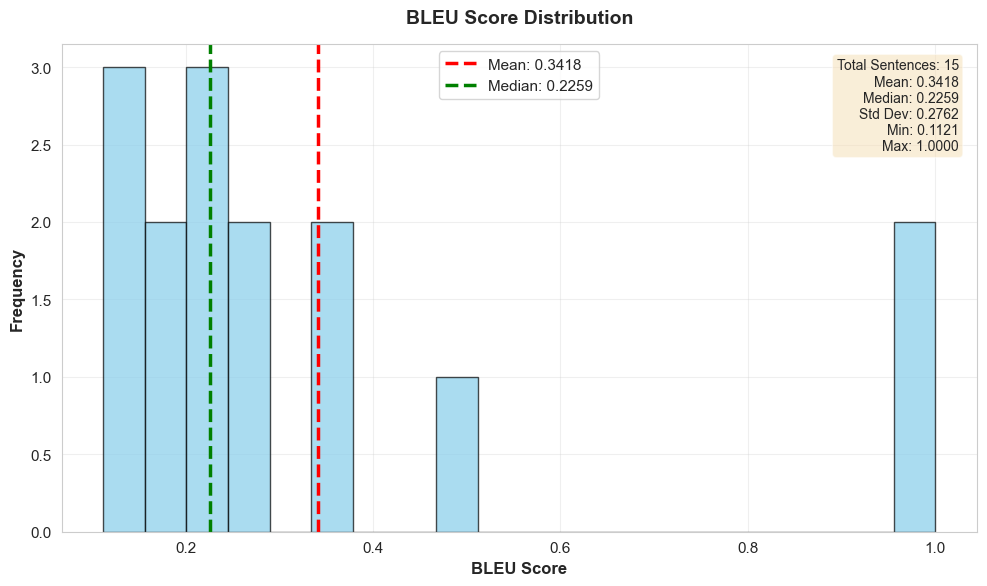


[2/10] Plot: N-gram Precision Bars
Saved: ./bleu_plots/2_ngram_precision.png


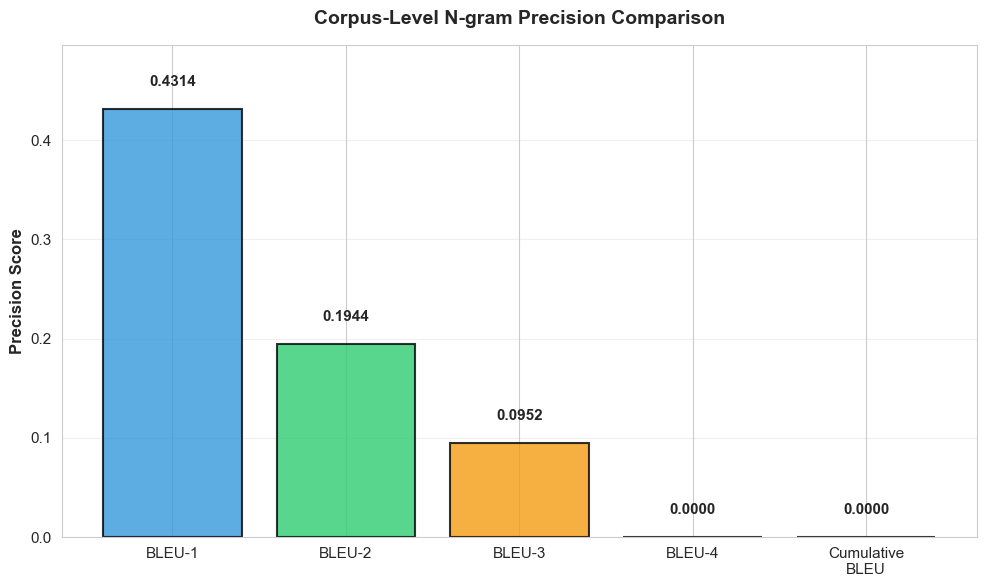


[3/10] Plot: Sentence-by-Sentence Scores
Saved: ./bleu_plots/3_sentence_scores.png


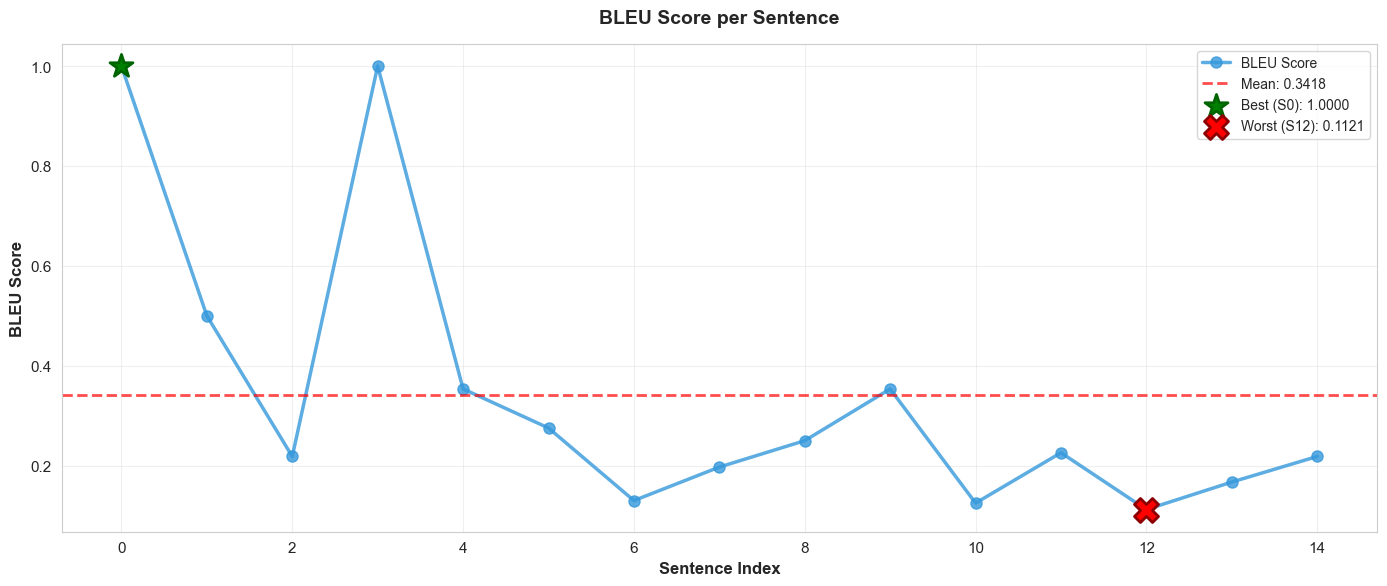


[4/10] Plot: N-gram Box Plot


C:\Users\SRI\AppData\Local\Temp\ipykernel_13900\2189722913.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Cumulative'],patch_artist=True, showmeans=True, meanline=True, widths=0.6)


Saved: ./bleu_plots/4_ngram_boxplot.png


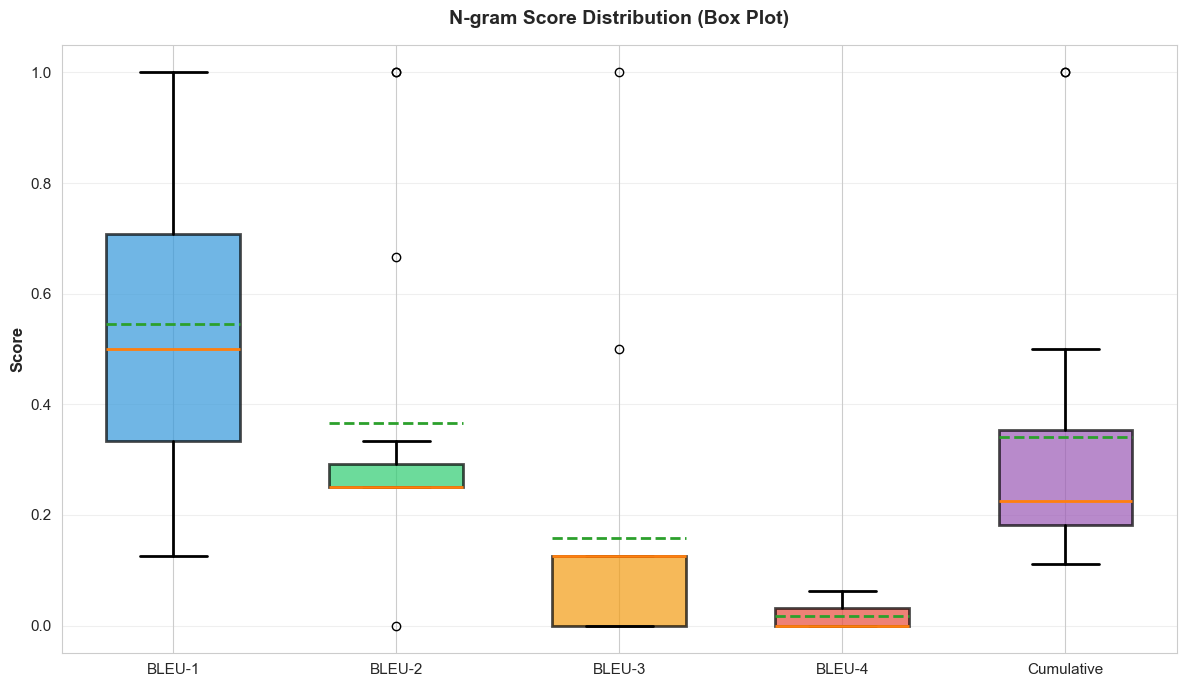


[5/10] Plot: N-gram Heatmap
Saved: ./bleu_plots/5_ngram_heatmap.png


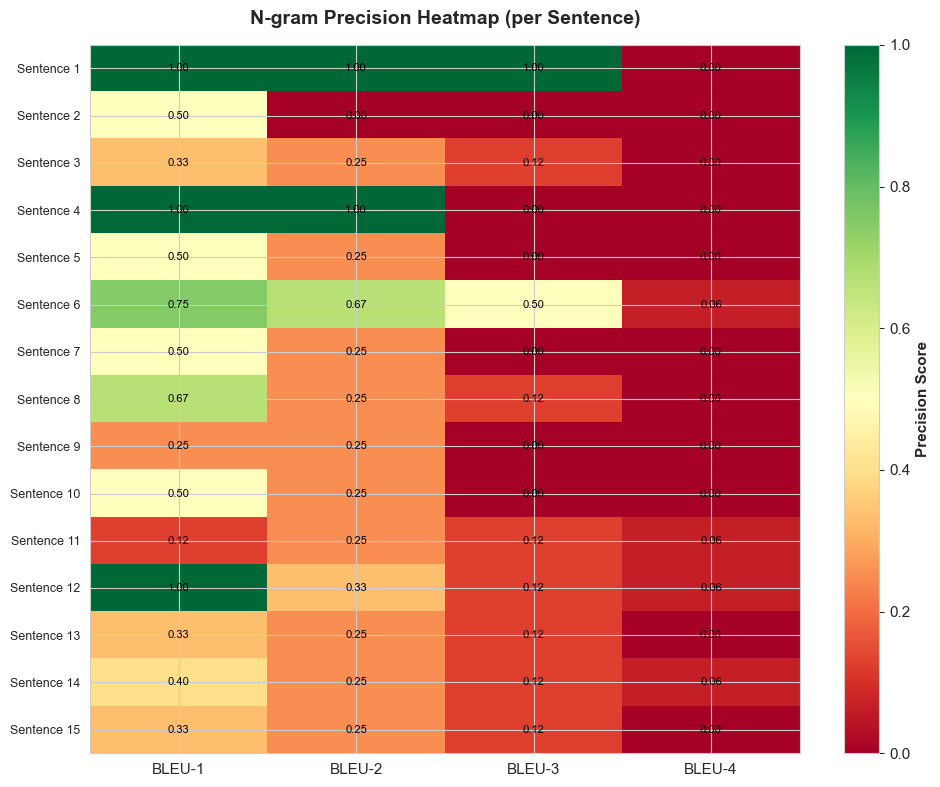


[6/10] Plot: Quality Pie Chart
Saved: ./bleu_plots/6_quality_distribution.png


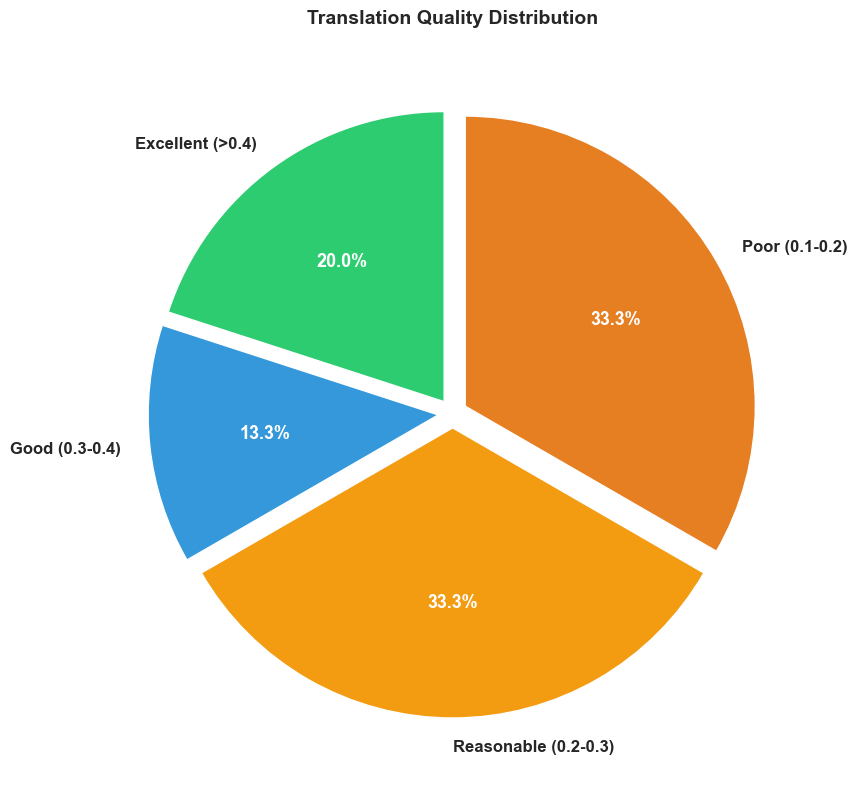


[7/10] Plot: Length vs BLEU
Saved: ./bleu_plots/7_length_vs_bleu.png


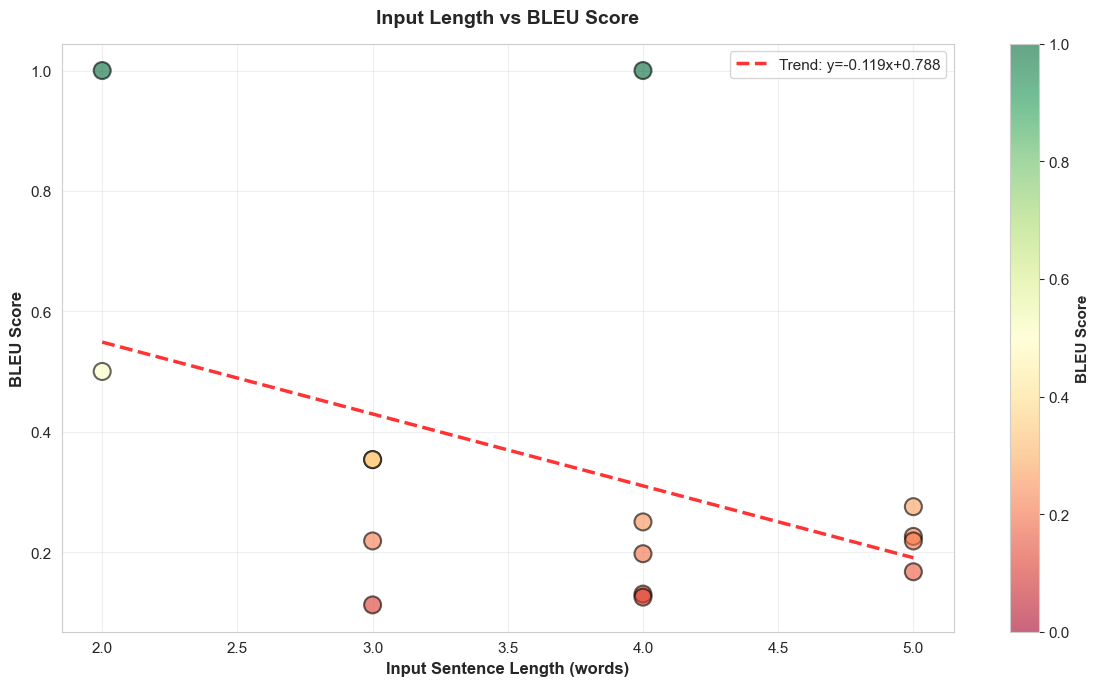


[8/10] Plot: Length Comparison
Saved: ./bleu_plots/8_length_comparison.png


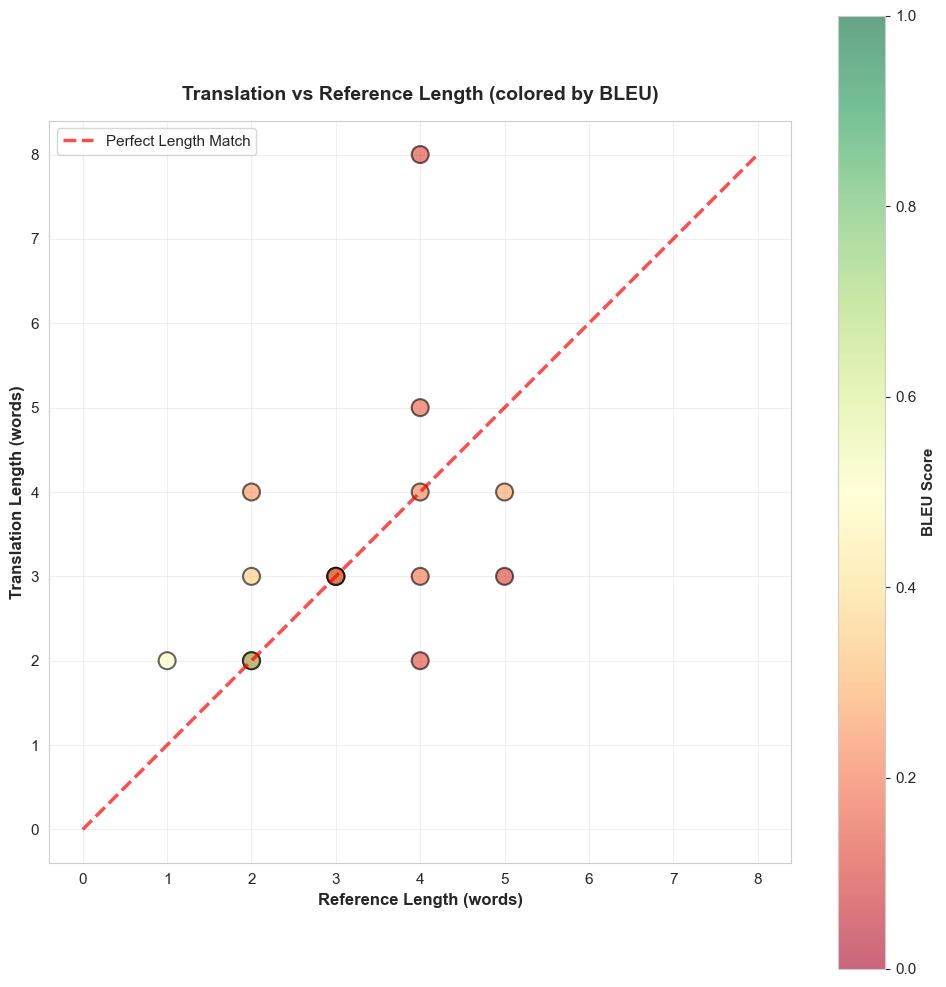


[9/10] Plot: Correlation Matrix
Saved: ./bleu_plots/9_correlation_matrix.png


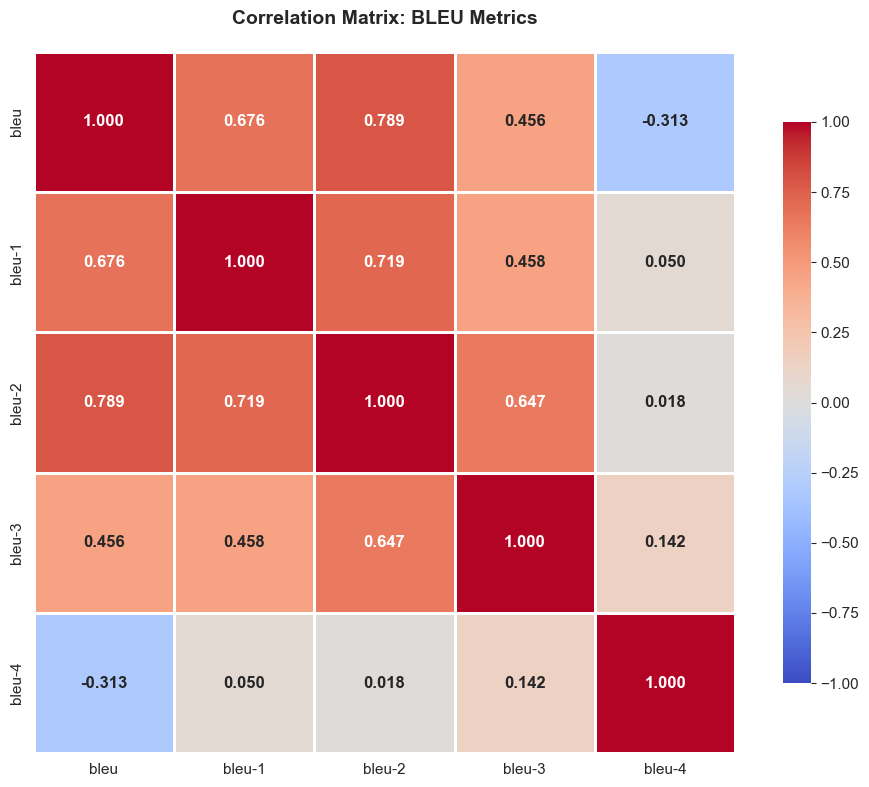


[10/10] Plot: Top/Bottom Examples
Saved: ./bleu_plots/10_top_bottom.png


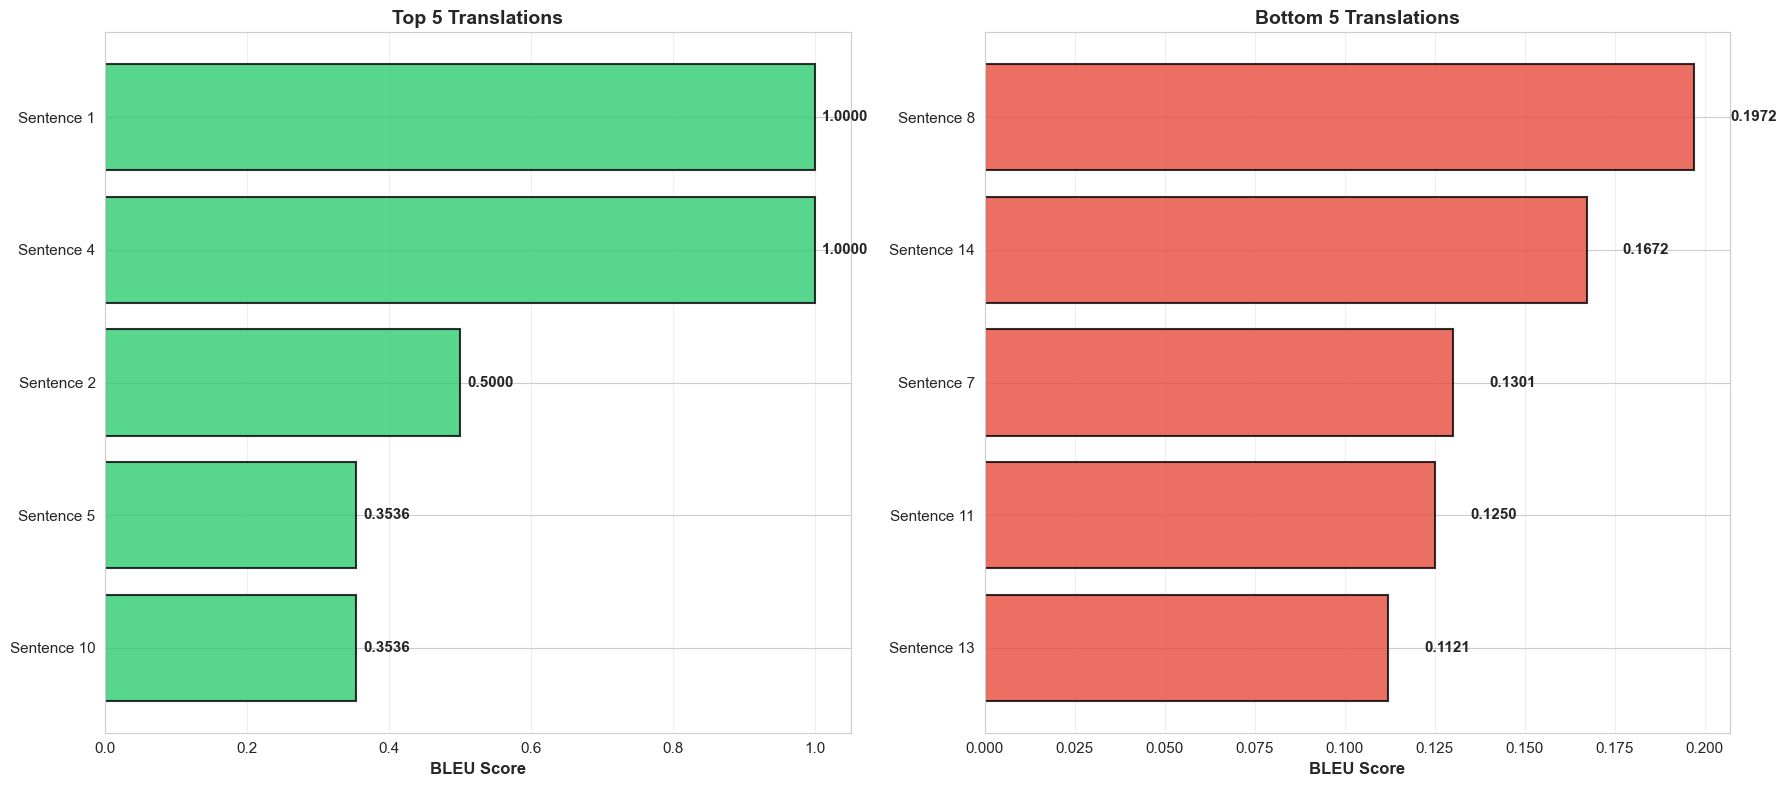

All plots saved to: C:\Users\SRI\Desktop\IIST\Data Modelling Lab\NMT_project\Final code files\bleu_plots


In [33]:
#Function calls for all the plots
results = evaluate_translations(model, eng_vocab, fr_vocab, test_data, device)
#Generate ans save all the plots
generate_all_plots(results, save_dir='./bleu_plots')